In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import pandas as pd

In [5]:
home_folder = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/'
# we need to coordinates file to access the corner points - glamf/gphif
model_mask_file = home_folder + 'GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values

<h4> Given a delta value- resolution of particles to be relased across a regular grid, compute the lats and lons of release points. \n Benguela Upwelling region lies between 10E-20E and 35S-20S ().

In [18]:
# Only upwelling region: (961, 641), 0.0625/4: #n: 370831
left_lon = 10.0
right_lon = 20.0
top_lat = -20
bottom_lat = -35

# extra region- FTLE: (1601, 1025), 0.0625/4 #n 1m
# left_lon = 5
# right_lon = 21
# top_lat = -15
# bottom_lat = -40
# Test region :
# left_lon = 17
# right_lon = 18
# top_lat = -30
# bottom_lat = -32
den=48
delta= 1/den
# delta = 0.0625/4  # divided by 4 (1601, 1025) 
# n=1,161,543(linear, but particles near 21E), 1,153,714(nearest) and without (401, 257) n=72,842

lons = np.arange(left_lon, right_lon + delta, delta)
lats = np.arange(bottom_lat, top_lat + delta, delta)
regions_lons, regions_lats = np.meshgrid(lons, lats)
print(regions_lons.shape)
print(delta)

(721, 481)
0.020833333333333332


In [19]:
points = list(zip(regions_lons.flatten(), regions_lats.flatten()))
release_lons, release_lats = zip(*points)

In [20]:
# land_val_release = griddata((mask_lon.ravel(), mask_lat.ravel()), mask_land[0,0,1:,1:].ravel(),
#                             (regions_lons, regions_lats), method='nearest', fill_value=0)
land_val_release = griddata((mask_lon[0, :-1, :-1].ravel(), mask_lat[0, :-1, :-1].ravel()), mask_land[0,0,1:,1:].ravel(),
                            (regions_lons, regions_lats), method='nearest', fill_value=0)
bool_mask = land_val_release.astype(bool)

In [6]:
# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_cropped_boolmask_961X641.npz', mask=bool_mask, lons=regions_lons, lats=regions_lats)

# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_cropped_boolmask_1601x1025.npz', mask=bool_mask, lons=regions_lons, lats=regions_lats)

In [21]:
ocean_lons = regions_lons[bool_mask]
ocean_lats = regions_lats[bool_mask]
len(ocean_lats)

208742

In [22]:
locations = pd.DataFrame(data=[ocean_lons, ocean_lats]).T
locations.columns=['Longitude', 'Latitude']
locations.to_csv('/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/Benguela_release_points_1ov{0}_{1}x{2}grid.csv'.format(den, regions_lons.shape[0], regions_lons.shape[1]),
        index=False, header=True, sep=',')

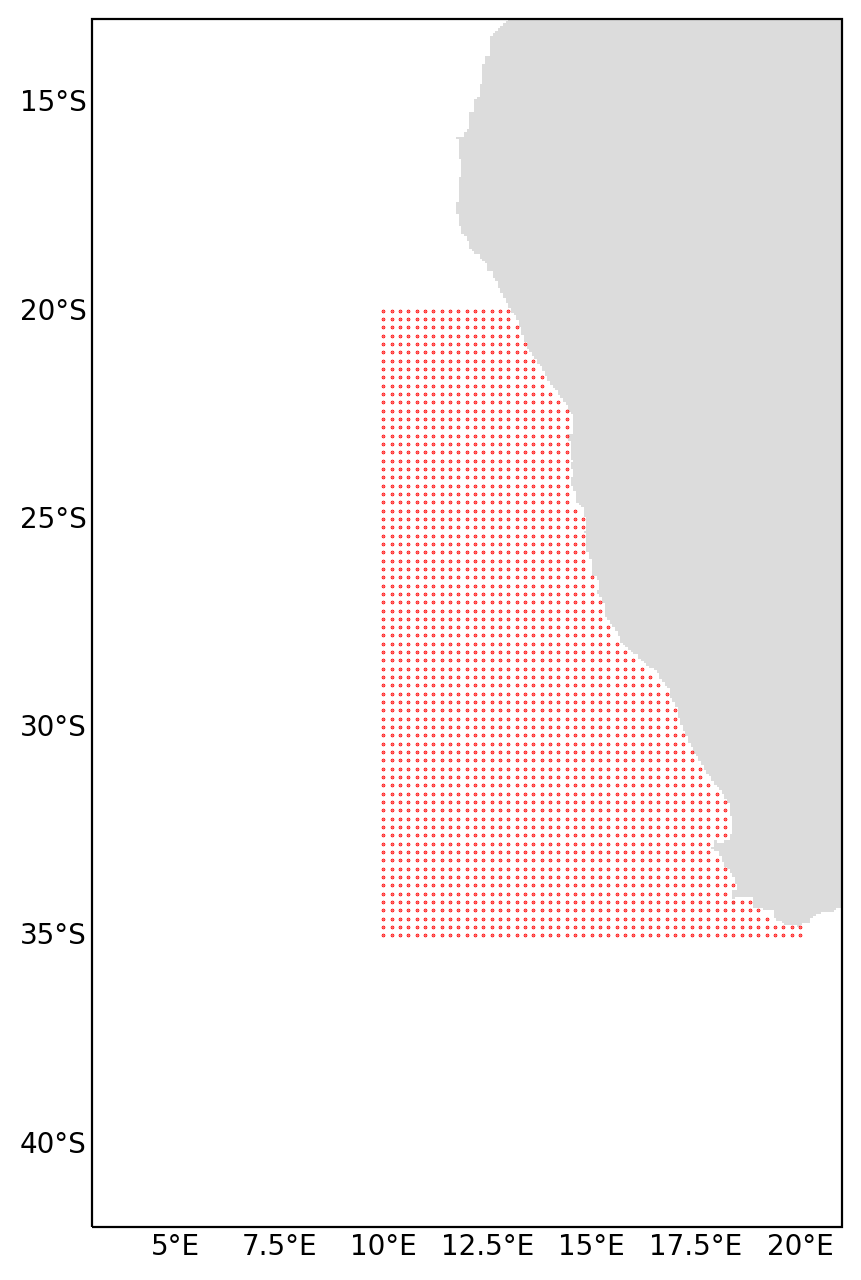

In [15]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
# ax.pcolormesh(mask_lon[0, :, :], mask_lat[0, :, :], mask_land[0,0, 1:, 1:], cmap=colormap)

# ax.scatter(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:],marker='X',s=0.3, c='red')
# ax.scatter(mask_lon[0, :, :], mask_lat[0, :, :], c=mask_land[0,0, :, :], cmap=plt.cm.Reds, s=0.5)
# ax.scatter(mask_lon[0, :, :], mask_lat[0, :, :],marker='X',s=0.3, c='red')


ax.set_xlim(3,21)
ax.set_ylim(-42,-13)
# ax.set_xlim(16.5,18.5)
# ax.set_ylim(-32.5,-29.5)
ax.scatter(ocean_lons, ocean_lats, s=0.1, c="red")
plt.show()

In [40]:
len(ocean_lons)

208742

In [8]:
# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_release_points_1by5_grid.npz',
#                     Longitude=ocean_lons,
#                     Latitude=ocean_lats)
# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_release_points_1601x1025_grid_015625.npz',
#                     Longitude=ocean_lons,
#                     Latitude=ocean_lats)

<h3> Example plot for computing FTLE with ocean release only</h3>
griddata method was later changed to 'nearest' as the filtering was not working well near 21E.


In [21]:
test_ds=xr.open_zarr('/nethome/manra003/analysis/dispersion/simulations/Test_Bkwd_2D_Benguela_0625_401x257_Dec01-31_2017_0z.zarr')
test_ds

<xarray.Dataset>
Dimensions:     (trajectory: 5596, obs: 16)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * trajectory  (trajectory) int64 0 1 2 3 4 5 ... 5590 5591 5592 5593 5594 5595
Data variables:
    lat         (trajectory, obs) float64 dask.array<chunksize=(5596, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 dask.array<chunksize=(5596, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(5596, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 dask.array<chunksize=(5596, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.4.1-265-g9573623b

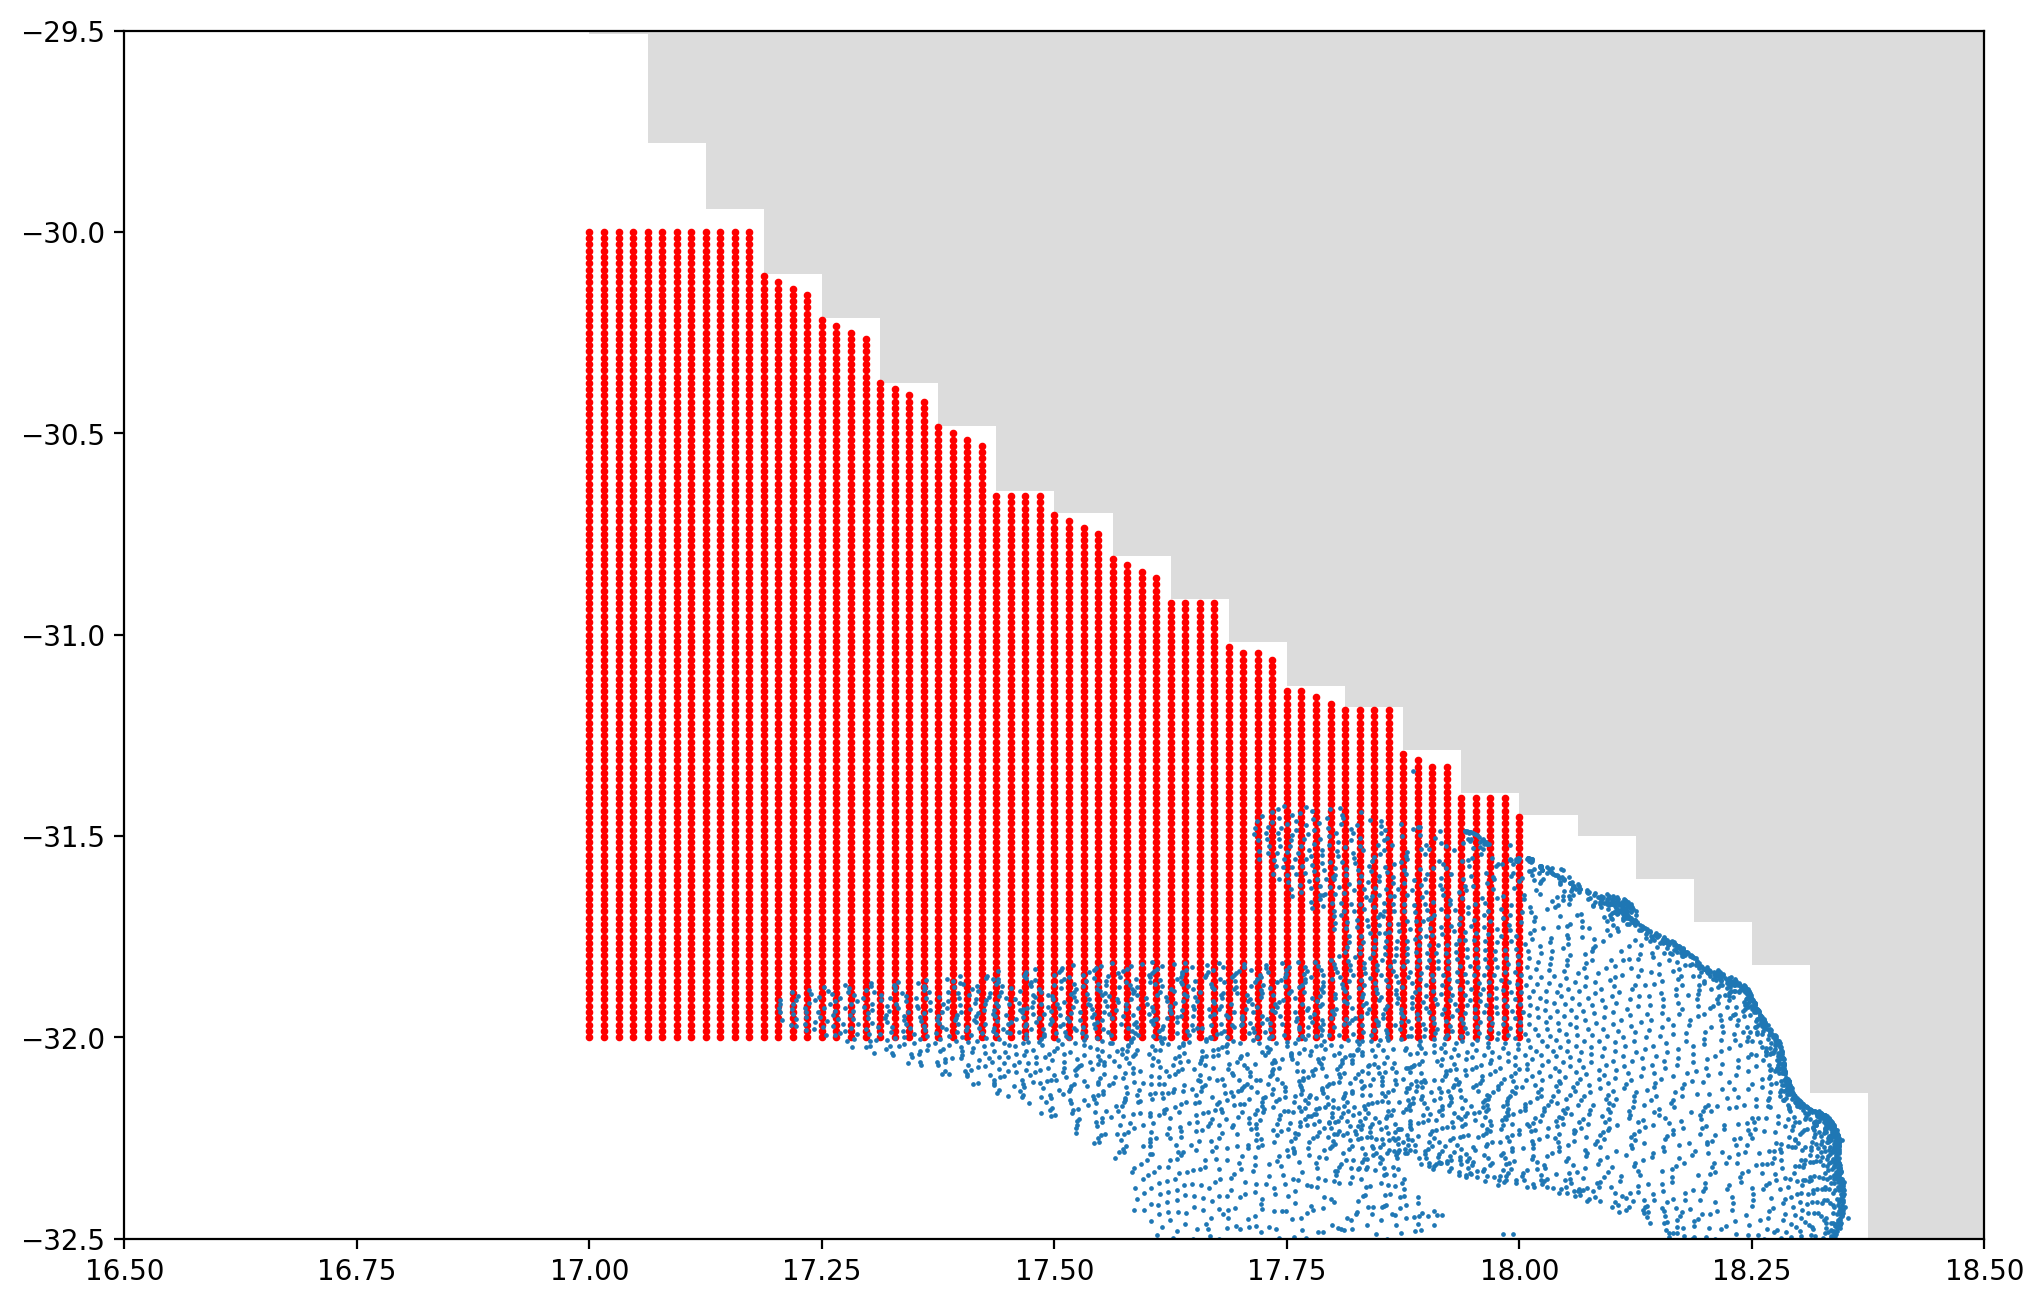

In [22]:
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes()
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)

ax.set_xlim(16.5,18.5)
ax.set_ylim(-32.5,-29.5)
ax.scatter(test_ds.lon[:,0], test_ds.lat[:,0], s=3, c='red')

ax.scatter(test_ds.lon[:,-1], test_ds.lat[:,-1], s=0.5)
plt.show()